# Importing libraries and classes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tabulate import tabulate
from sklearn.metrics import (
    median_absolute_error,
    max_error,
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    explained_variance_score,
)
from sklearn.model_selection import train_test_split, KFold
from Utils import Utils
from DecisionTreeRegressor import DecisionTreeRegressor
from RandomForestRegressor import RandomForestRegressor
from LinearRegression import LinearRegression
from itertools import product

# Reading and splitting the data

In [2]:
# Load the dataset
df = pd.read_csv('./NSO_Population_Sex_dataset/NSO_POPULATION_DATA_CLEANED.csv')

# Define feature columns and target variable
feature_cols = ['District', 'Sex', 'Year', 'Population_Growth_Rate', 'Average_Population']
X = pd.get_dummies(df[feature_cols], columns=['District', 'Sex'])
y = df["Population"]

# Custom Implementations - Decision Tree, Random Forest, Linear Regression

In [3]:
# Custom hyperparameter tuning & cross validation function
def custom_hyperparameter_tuning(X, y, parameter_grid, algorithm, num_splits=10):
    best_params = None
    best_mse = float('inf')

    kf = KFold(n_splits=num_splits, shuffle=True, random_state=42)

    for params in parameter_grid:
        mse_sum = 0

        for train_index, val_index in kf.split(X):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            if algorithm == 'DT':
                model = DecisionTreeRegressor(params['min_samples_split'], params['max_depth'])
                model.fit(X_train.values, y_train.values)
                predictions = model.predict(X_val.values)
                mse_sum += mean_squared_error(y_val, predictions)
            elif algorithm == 'RF':
                model = RandomForestRegressor(params['n_estimators'], params['min_samples_split'], params['max_depth'])
                model.fit(X_train, y_train)
                predictions = model.predict(X_val)
                mse_sum += mean_squared_error(y_val, predictions)
            elif algorithm == 'LR':
                model = LinearRegression(params['learning_rate'], params['num_iterations'])
                model.fit(X_train.values, y_train.values)
                predictions = model.predict(X_val.values)
                mse_sum += mean_squared_error(y_val, predictions)

        mse = mse_sum / num_splits

        if mse < best_mse:
            best_params = params
            best_mse = mse

    return best_params

In [4]:
# Hyperparameters for Decision Tree, Random Forest, and Linear Regression
DT_Parameters = {'min_samples_split': [2, 3, 4, 5, 10, 15, 20], 'max_depth': [10, 25, 50, 75, 100, 125, 150, 175, 200]}
DT_Parameters = list(product(DT_Parameters['min_samples_split'], DT_Parameters['max_depth']))
DT_Parameters = [{'min_samples_split': min_samples, 'max_depth': max_depth} for min_samples, max_depth in DT_Parameters]

RF_Parameters = {'n_estimators': [75, 100, 125], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20], 'max_depth': [10, 25, 50, 75, 100, 125, 150, 175, 200]}
RF_Parameters = list(product(RF_Parameters['n_estimators'], RF_Parameters['min_samples_split'], RF_Parameters['max_depth']))
RF_Parameters = [{'n_estimators': n_estimators, 'min_samples_split': min_samples, 'max_depth': max_depth} for n_estimators, min_samples, max_depth in RF_Parameters]

LR_Parameters = {'learning_rate': [0.001, 0.01, 0.1, 1], 'num_iterations': [50, 100, 250, 500, 750, 1000, 1250, 1500]}
LR_Parameters = list(product(LR_Parameters['learning_rate'], LR_Parameters['num_iterations']))
LR_Parameters = [{'learning_rate': learning_rate, 'num_iterations': num_iterations} for learning_rate, num_iterations in LR_Parameters]

DT_Total_Time, DT_Total_MSE, DT_Total_MAE, DT_Total_RMSE, DT_Total_R2, DT_Total_Explained_Variance, DT_Total_MedianAE, DT_Total_MaxError = [0.0] * 8
RF_Total_Time, RF_Total_MSE, RF_Total_MAE, RF_Total_RMSE, RF_Total_R2, RF_Total_Explained_Variance, RF_Total_MedianAE, RF_Total_MaxError = [0.0] * 8
LR_Total_Time, LR_Total_MSE, LR_Total_MAE, LR_Total_RMSE, LR_Total_R2, LR_Total_Explained_Variance, LR_Total_MedianAE, LR_Total_MaxError = [0.0] * 8

# Perform multiple runs
NUMBER_OF_RUNS = 10
All_Actual_Values, DT_All_Best_Predictions, RF_All_Best_Predictions, LR_All_Best_Predictions = [], [], [], []

for run in range(NUMBER_OF_RUNS):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=run)
    All_Actual_Values.append(y_test)

    # Decision Tree
    best_params_dt = custom_hyperparameter_tuning(X_train, y_train, DT_Parameters, 'DT')
    DT_Start_Time = time.time()
    DT_model = DecisionTreeRegressor(best_params_dt['min_samples_split'], best_params_dt['max_depth'])
    DT_model.fit(X_train, y_train)
    DT_Best_Prediction = DT_model.predict(X_test.values)
    DT_End_Time = time.time()
    DT_All_Best_Predictions.append(DT_Best_Prediction)
    DT_Total_Time += DT_End_Time - DT_Start_Time
    DT_Total_MSE += mean_squared_error(y_test, DT_Best_Prediction)
    DT_Total_MAE += mean_absolute_error(y_test, DT_Best_Prediction)
    DT_Total_RMSE += Utils.root_mean_squared_error(y_test, DT_Best_Prediction)
    DT_Total_R2 += r2_score(y_test, DT_Best_Prediction)
    DT_Total_Explained_Variance += explained_variance_score(y_test, DT_Best_Prediction)
    DT_Total_MedianAE += median_absolute_error(y_test, DT_Best_Prediction)
    DT_Total_MaxError += max_error(y_test, DT_Best_Prediction)

    # Random Forest
    best_params_rf = custom_hyperparameter_tuning(X_train, y_train, RF_Parameters, 'RF')
    RF_Start_Time = time.time()
    RF_model = RandomForestRegressor(best_params_rf['n_estimators'], best_params_rf['min_samples_split'], best_params_rf['max_depth'])
    RF_model.fit(X_train, y_train)
    RF_Best_Prediction = RF_model.predict(X_test)
    RF_End_Time = time.time()
    RF_All_Best_Predictions.append(RF_Best_Prediction)
    RF_Total_Time += RF_End_Time - RF_Start_Time
    RF_Total_MSE += mean_squared_error(y_test, RF_Best_Prediction)
    RF_Total_MAE += mean_absolute_error(y_test, RF_Best_Prediction)
    RF_Total_RMSE += Utils.root_mean_squared_error(y_test, RF_Best_Prediction)
    RF_Total_R2 += r2_score(y_test, RF_Best_Prediction)
    RF_Total_Explained_Variance += explained_variance_score(y_test, RF_Best_Prediction)
    RF_Total_MedianAE += median_absolute_error(y_test, RF_Best_Prediction)
    RF_Total_MaxError += max_error(y_test, RF_Best_Prediction)

    # Linear Regression
    best_params_lr = custom_hyperparameter_tuning(X_train, y_train, LR_Parameters, 'LR')
    LR_Start_Time = time.time()
    LR_model = LinearRegression(best_params_lr['learning_rate'], best_params_lr['num_iterations'])
    LR_model.fit(X_train.values, y_train.values)
    LR_Best_Prediction = LR_model.predict(X_test.values)
    LR_End_Time = time.time()
    LR_All_Best_Predictions.append(LR_Best_Prediction)
    LR_Total_Time += LR_End_Time - LR_Start_Time
    LR_Total_MSE += mean_squared_error(y_test, LR_Best_Prediction)
    LR_Total_MAE += mean_absolute_error(y_test, LR_Best_Prediction)
    LR_Total_RMSE += Utils.root_mean_squared_error(y_test, LR_Best_Prediction)
    LR_Total_R2 += r2_score(y_test, LR_Best_Prediction)
    LR_Total_Explained_Variance += explained_variance_score(y_test, LR_Best_Prediction)
    LR_Total_MedianAE += median_absolute_error(y_test, LR_Best_Prediction)
    LR_Total_MaxError += max_error(y_test, LR_Best_Prediction)

    print(f"Run {run + 1}")

# Finding average values across all runs
Average_Actual_Values = np.mean(All_Actual_Values, axis=0)
DT_Average_Predictions = np.mean(DT_All_Best_Predictions, axis=0)
DT_Average_Time = DT_Total_Time / NUMBER_OF_RUNS
DT_Average_MSE = DT_Total_MSE / NUMBER_OF_RUNS
DT_Average_MAE = DT_Total_MAE / NUMBER_OF_RUNS
DT_Average_RMSE = DT_Total_RMSE / NUMBER_OF_RUNS
DT_Average_R2 = DT_Total_R2 / NUMBER_OF_RUNS
DT_Average_Explained_Variance = DT_Total_Explained_Variance / NUMBER_OF_RUNS
DT_Average_MedianAE = DT_Total_MedianAE / NUMBER_OF_RUNS
DT_Average_MaxError = DT_Total_MaxError / NUMBER_OF_RUNS

RF_Average_Predictions = np.mean(RF_All_Best_Predictions, axis=0)
RF_Average_Time = RF_Total_Time / NUMBER_OF_RUNS
RF_Average_MSE = RF_Total_MSE / NUMBER_OF_RUNS
RF_Average_MAE = RF_Total_MAE / NUMBER_OF_RUNS
RF_Average_RMSE = RF_Total_RMSE / NUMBER_OF_RUNS
RF_Average_R2 = RF_Total_R2 / NUMBER_OF_RUNS
RF_Average_Explained_Variance = RF_Total_Explained_Variance / NUMBER_OF_RUNS
RF_Average_MedianAE = RF_Total_MedianAE / NUMBER_OF_RUNS
RF_Average_MaxError = RF_Total_MaxError / NUMBER_OF_RUNS

LR_Average_Predictions = np.mean(LR_All_Best_Predictions, axis=0)
LR_Average_Time = LR_Total_Time / NUMBER_OF_RUNS
LR_Average_MSE = LR_Total_MSE / NUMBER_OF_RUNS
LR_Average_MAE = LR_Total_MAE / NUMBER_OF_RUNS
LR_Average_RMSE = LR_Total_RMSE / NUMBER_OF_RUNS
LR_Average_R2 = LR_Total_R2 / NUMBER_OF_RUNS
LR_Average_Explained_Variance = LR_Total_Explained_Variance / NUMBER_OF_RUNS
LR_Average_MedianAE = LR_Total_MedianAE / NUMBER_OF_RUNS
LR_Average_MaxError = LR_Total_MaxError / NUMBER_OF_RUNS


# Printing out values
print("All_Actual_Values: ", All_Actual_Values)
print("DT_All_Best_Predictions: ", DT_All_Best_Predictions)
print("RF_All_Best_Predictions: ", RF_All_Best_Predictions)
print("LR_All_Best_Predictions: ", LR_All_Best_Predictions)

print("\nAverage_Actual_Values: ", Average_Actual_Values)
print("DT_Average_Predictions: ", DT_Average_Predictions)
print("RF_Average_Predictions: ", RF_Average_Predictions)
print("LR_Average_Predictions: ", LR_Average_Predictions)

print(f"\nDecision Tree Metrics over {NUMBER_OF_RUNS} runs:")
print(f"Average Execution Time in seconds: {DT_Average_Time:.6f}")
print(f"Average Mean Squared Error: {DT_Average_MSE:.6f}")
print(f"Average Root Mean Squared Error: {DT_Average_RMSE:.6f}")
print(f"Average Mean Absolute Error: {DT_Average_MAE:.6f}")
print(f"Average R Squared: {DT_Average_R2:.6f}")
print(f"Average Explained Variance: {DT_Average_Explained_Variance:.6f}")
print(f"Average Median Absolute Error: {DT_Average_MedianAE:.6f}")
print(f"Average Maximum Absolute Error: {DT_Average_MaxError:.6f}")

print(f"\nRandom Forest Metrics over {NUMBER_OF_RUNS} runs:")
print(f"Average Execution Time in seconds: {RF_Average_Time:.6f}")
print(f"Average Mean Squared Error: {RF_Average_MSE:.6f}")
print(f"Average Root Mean Squared Error: {RF_Average_RMSE:.6f}")
print(f"Average Mean Absolute Error: {RF_Average_MAE:.6f}")
print(f"Average R Squared: {RF_Average_R2:.6f}")
print(f"Average Explained Variance: {RF_Average_Explained_Variance:.6f}")
print(f"Average Median Absolute Error: {RF_Average_MedianAE:.6f}")
print(f"Average Maximum Absolute Error: {RF_Average_MaxError:.6f}")

print(f"\nLinear Regression Metrics over {NUMBER_OF_RUNS} runs:")
print(f"Average Execution Time in seconds: {LR_Average_Time:.6f}")
print(f"Average Mean Squared Error: {LR_Average_MSE:.6f}")
print(f"Average Root Mean Squared Error: {LR_Average_RMSE:.6f}")
print(f"Average Mean Absolute Error: {LR_Average_MAE:.6f}")
print(f"Average R Squared: {LR_Average_R2:.6f}")
print(f"Average Explained Variance: {LR_Average_Explained_Variance:.6f}")
print(f"Average Median Absolute Error: {LR_Average_MedianAE:.6f}")
print(f"Average Maximum Absolute Error: {LR_Average_MaxError:.6f}")

Run 1
Run 2
Run 3
Run 4
Run 5
Run 6
Run 7
Run 8
Run 9
Run 10
All_Actual_Values:  [110    0.220062
74     0.267133
163    0.005896
97     0.173876
126    0.211856
71     0.241120
18     0.334591
157    0.361599
145    0.183734
7      0.327017
5      0.327930
139    0.292650
158    0.400089
170    0.009978
160    0.005842
167    0.007185
37     0.589302
66     0.205128
138    0.273432
122    0.198238
56     0.652731
187    0.010368
136    0.240905
182    0.003895
191    0.029411
152    0.237668
63     0.894065
60     0.797599
161    0.005076
33     0.584279
4      0.332201
55     0.631230
96     0.173218
44     0.828649
45     0.898457
26     0.333557
178    0.000846
180    0.003344
113    0.181330
Name: Population, dtype: float64, 44     0.828649
69     0.225675
161    0.005076
35     0.589261
182    0.003895
11     0.336176
122    0.198238
81     0.196801
110    0.220062
180    0.003344
172    0.014773
127    0.212111
29     0.345026
16     0.340635
108    0.200669
67     0.213333
28  

In [5]:
# Ensuring actual and predicted value lists are numeric arrays
Average_Actual_Values_Numeric = np.asarray(Average_Actual_Values, dtype=np.float64)
DT_Average_Prediction_Numeric = np.asarray(DT_Average_Predictions, dtype=np.float64)
RF_Average_Prediction_Numeric = np.asarray(RF_Average_Predictions, dtype=np.float64)
LR_Average_Prediction_Numeric = np.asarray(LR_Average_Predictions, dtype=np.float64)

# Scatter Plot - Average Actual vs Average Predicted values

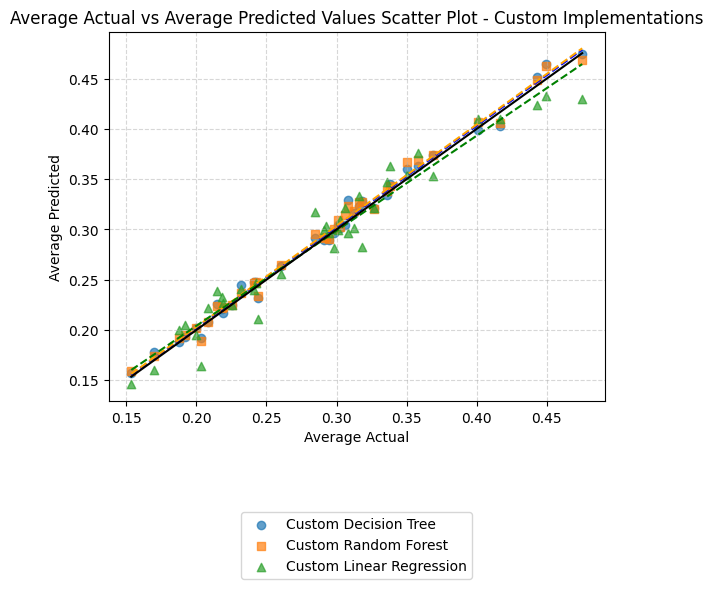

In [6]:
# Custom Decision Tree vs Custom Random Forest vs Custom Linear Regression
plt.scatter(Average_Actual_Values_Numeric, DT_Average_Prediction_Numeric, alpha=0.7, marker='o', label='Custom Decision Tree')
plt.scatter(Average_Actual_Values_Numeric, RF_Average_Prediction_Numeric, alpha=0.7, marker='s', label='Custom Random Forest')
plt.scatter(Average_Actual_Values_Numeric, LR_Average_Prediction_Numeric, alpha=0.7, marker='^', label='Custom Linear Regression')

# Regression lines
plt.plot(np.unique(Average_Actual_Values_Numeric), np.poly1d(np.polyfit(Average_Actual_Values_Numeric, DT_Average_Prediction_Numeric, 1))(np.unique(Average_Actual_Values_Numeric)), color='blue', linestyle='--')
plt.plot(np.unique(Average_Actual_Values_Numeric), np.poly1d(np.polyfit(Average_Actual_Values_Numeric, RF_Average_Prediction_Numeric, 1))(np.unique(Average_Actual_Values_Numeric)), color='orange', linestyle='--')
plt.plot(np.unique(Average_Actual_Values_Numeric), np.poly1d(np.polyfit(Average_Actual_Values_Numeric, LR_Average_Prediction_Numeric, 1))(np.unique(Average_Actual_Values_Numeric)), color='green', linestyle='--')

# Reference line
plt.plot([min(Average_Actual_Values_Numeric), max(Average_Actual_Values_Numeric)], [min(Average_Actual_Values_Numeric), max(Average_Actual_Values_Numeric)], linestyle='-', color='black')

plt.xlabel('Average Actual')
plt.ylabel('Average Predicted')
plt.title('Average Actual vs Average Predicted Values Scatter Plot - Custom Implementations')

plt.legend(['Custom Decision Tree', 'Custom Random Forest', 'Custom Linear Regression'], loc='lower center', bbox_to_anchor=(0.5,-0.5))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Residual Plot - Residuals vs Average Predicted Values

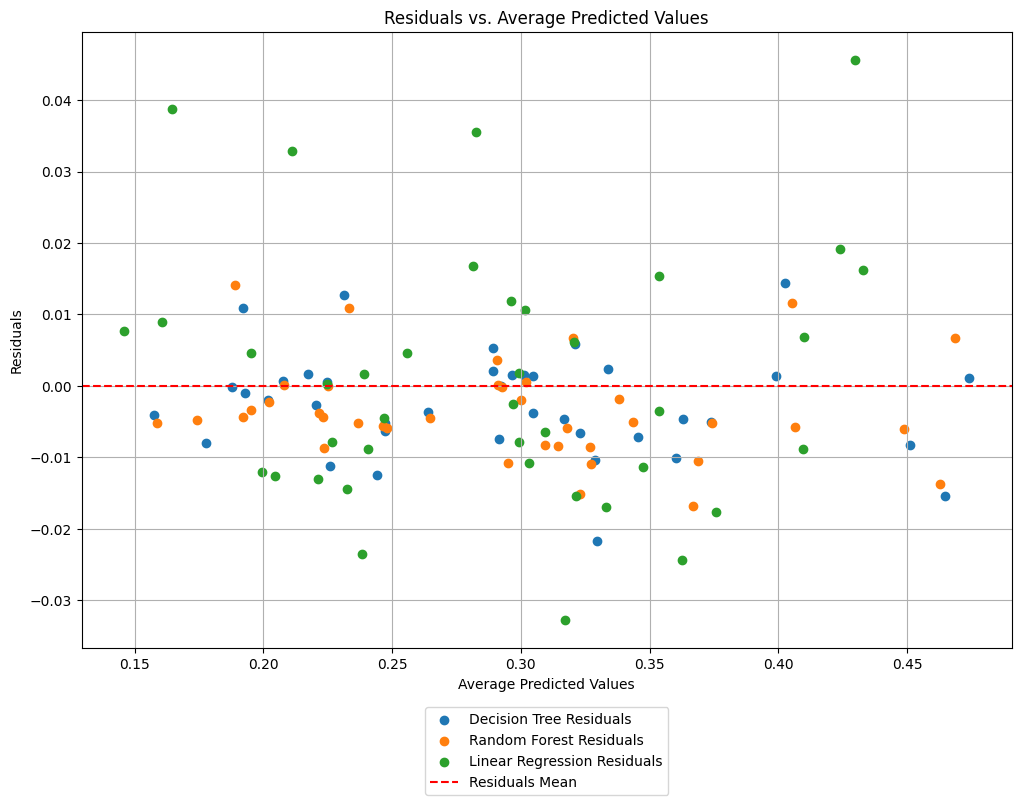

In [7]:
DT_Residuals = Average_Actual_Values_Numeric - DT_Average_Prediction_Numeric
RF_Residuals = Average_Actual_Values_Numeric - RF_Average_Prediction_Numeric
LR_Residuals = Average_Actual_Values_Numeric - LR_Average_Prediction_Numeric

# Residuals vs Average Predicted Values for all models
plt.figure(figsize=(12, 8))
plt.scatter(DT_Average_Prediction_Numeric, DT_Residuals, label='Decision Tree Residuals')
plt.scatter(RF_Average_Prediction_Numeric, RF_Residuals, label='Random Forest Residuals')
plt.scatter(LR_Average_Prediction_Numeric, LR_Residuals, label='Linear Regression Residuals')
plt.axhline(y=0, color='r', linestyle='--', label='Residuals Mean')
plt.xlabel('Average Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Average Predicted Values')
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.25))
plt.grid(True)
plt.show()

# Actual vs Predicted Values

╒═════════════════════════╤═══════════════════════════════╤═══════════════════════════════╤═══════════════════════════════╕
│   Average Actual Values │   Average DT Predicted Values │   Average RF Predicted Values │   Average LR Predicted Values │
╞═════════════════════════╪═══════════════════════════════╪═══════════════════════════════╪═══════════════════════════════╡
│                0.400704 │                      0.39926  │                      0.406523 │                      0.409573 │
├─────────────────────────┼───────────────────────────────┼───────────────────────────────┼───────────────────────────────┤
│                0.294329 │                      0.289078 │                      0.290731 │                      0.296888 │
├─────────────────────────┼───────────────────────────────┼───────────────────────────────┼───────────────────────────────┤
│                0.326915 │                      0.321093 │                      0.320212 │                      0.320846 │
├───────

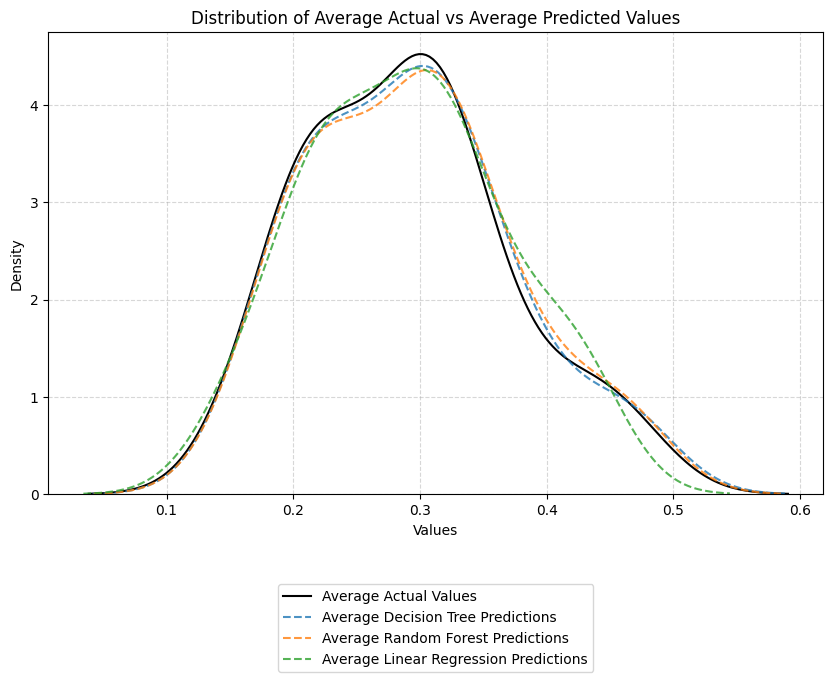

In [8]:
results_table_data = {
    'Average Actual Values': Average_Actual_Values_Numeric,
    'Average DT Predicted Values': DT_Average_Prediction_Numeric,
    'Average RF Predicted Values': RF_Average_Prediction_Numeric,
    'Average LR Predicted Values': LR_Average_Prediction_Numeric
}

print(tabulate(results_table_data, headers='keys', tablefmt='fancy_grid'))

plt.figure(figsize=(10, 6))
sns.kdeplot(Average_Actual_Values_Numeric, label='Average Actual Values', color='black', linestyle='-')
sns.kdeplot(DT_Average_Prediction_Numeric, label='Average Decision Tree Predictions', alpha=0.8, linestyle='--')
sns.kdeplot(RF_Average_Prediction_Numeric, label='Average Random Forest Predictions', alpha=0.8, linestyle='--')
sns.kdeplot(LR_Average_Prediction_Numeric, label='Average Linear Regression Predictions', alpha=0.8, linestyle='--')
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Distribution of Average Actual vs Average Predicted Values')
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.4))
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Average: Execution time in seconds, Mean Absolute Error, Median Absolute Error, Mean Squared Error, Root Mean Squared Error, R Squared, Explained Variance, Maximum Absolute Error

In [9]:
table_data = {
    '': ['Custom Decision Tree Regressor', 'Custom Random Forest Regressor', 'Custom Linear Regression'],
    'Average Execution Time in seconds': [DT_Average_Time, RF_Average_Time, LR_Average_Time],
    'Average Mean Absolute Error': [DT_Average_MAE, RF_Average_MAE, LR_Average_MAE],
    'Average Median Absolute Error': [DT_Average_MedianAE, RF_Average_MedianAE, LR_Average_MedianAE],
    'Average Mean Squared Error': [DT_Average_MSE, RF_Average_MSE, LR_Average_MSE],
    'Average Root Mean Squared Error': [DT_Average_RMSE, RF_Average_RMSE, LR_Average_RMSE],
    'Average R Squared': [DT_Average_R2, RF_Average_R2, LR_Average_R2],
    'Average Explained Variance': [DT_Average_Explained_Variance, RF_Average_Explained_Variance, LR_Average_Explained_Variance],
    'Average Maximum Absolute Error': [DT_Average_MaxError, RF_Average_MaxError, LR_Average_MaxError]
}

print(tabulate(table_data, headers='keys', tablefmt='fancy_grid'))

╒════════════════════════════════╤═════════════════════════════════════╤═══════════════════════════════╤═════════════════════════════════╤══════════════════════════════╤═══════════════════════════════════╤═════════════════════╤══════════════════════════════╤══════════════════════════════════╕
│                                │   Average Execution Time in seconds │   Average Mean Absolute Error │   Average Median Absolute Error │   Average Mean Squared Error │   Average Root Mean Squared Error │   Average R Squared │   Average Explained Variance │   Average Maximum Absolute Error │
╞════════════════════════════════╪═════════════════════════════════════╪═══════════════════════════════╪═════════════════════════════════╪══════════════════════════════╪═══════════════════════════════════╪═════════════════════╪══════════════════════════════╪══════════════════════════════════╡
│ Custom Decision Tree Regressor │                           0.111625  │                     0.0117928 │              